Best attempts at reproducing minimal version of an algorithm proposed at https://arxiv.org/abs/2205.14977. Original code can be found [here](https://github.com/vistalab-technion/vqr)

In [2]:
from sklearn.preprocessing import StandardScaler
from data_utils import create_joint_x_y
import numpy as np

def create_multidimensional_0_1_grid(T: int, d: int):
    """
    Create a evenly spaced multidimensional grid of size T^d.
    """
    U_grids = np.meshgrid(*([(np.arange(T) + 1) * (1 / T)] * d))
    U = np.stack([U_grid.reshape(-1) for U_grid in U_grids], axis=1)
    return U

num_points_to_generate = 750

X, Y = create_joint_x_y(num_points_to_generate)

n, q = Y.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled[:, None] if len(X_scaled.shape) == 1 else X_scaled
U = create_multidimensional_0_1_grid(27, q)

m = U.shape[0]

nu = np.ones((n, 1)) / n
mu = np.ones((m, 1)) / m

In [3]:
import torch
torch.manual_seed(0)

device_and_dtype_specifications = dict(dtype=torch.float64, device=torch.device("cpu"))
epsilon = 0.1
num_epochs = 5000

U_tensor = torch.tensor(U, **device_and_dtype_specifications)
Y_tensor = torch.tensor(Y, **device_and_dtype_specifications)
X_tensor = torch.tensor(X_scaled, **device_and_dtype_specifications)
nu_tensor = torch.tensor(nu, **device_and_dtype_specifications)
mu_tensor = torch.tensor(mu, **device_and_dtype_specifications)

psi_tensor = torch.full(size=(Y_tensor.shape[0], 1), fill_value=0.1, requires_grad=True, **device_and_dtype_specifications)
b_tensor = torch.zeros(*(m, 1), requires_grad=True, **device_and_dtype_specifications)

optimizer = torch.optim.AdamW([dict(params=[b_tensor, psi_tensor])], lr=0.1)

for epoch_idx in range(num_epochs):
        optimizer.zero_grad()

        phi_tensor = epsilon * torch.logsumexp(
                U_tensor @ Y_tensor.T  - # (m, q) @ (q, N)
                b_tensor @ X_tensor.T - # (m, 1) @ (1, N)
                psi_tensor.reshape(1, -1) # (N, 1).reshape(1, N)
                , dim = 1
        ) # (m, 1)

        objective = psi_tensor.T @ nu_tensor + phi_tensor.T @ mu_tensor # (N, 1).T @ (N, 1) + (m, 1).T @ (m, 1)

        objective.backward()
        optimizer.step()

with torch.no_grad():
        phi_tensor = epsilon * torch.logsumexp(
                U_tensor @ Y_tensor.T  - # (m, q) @ (q, N)
                b_tensor @ X_tensor.T - # (m, 1) @ (1, N)
                psi_tensor.reshape(1, -1) # (N, 1).reshape(1, N)
                , dim = 1
        ) # (m, 1)

A = phi_tensor.detach().cpu().numpy() # (m, 1)
B = b_tensor.detach().cpu().numpy() # (m, 1)

/var/folders/df/4t1l5hys3y7f1qn1w20x2cjw0000gn/T/ipykernel_4532/64105485.py:29: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4416.)
  objective = psi_tensor.T @ nu_tensor + phi_tensor.T @ mu_tensor # (N, 1).T @ (N, 1) + (m, 1).T @ (m, 1)


In [4]:
x = X_scaled[0:1, :]
phi_u = B @ x + A[:, None]  # result is (T**d, 1)

In [6]:
import matplotlib.pyplot as plt

%matplotlib qt

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(U[:, 0], U[:, 1], phi_u[:, 0], color='red', marker='o', s=30, alpha=0.6)
ax.grid(True)

ax.view_init(elev=20, azim=120)
ax.set_xlabel('u1')
ax.set_ylabel('u2')
ax.set_zlabel('phi_u')

plt.show()

In [18]:
phi_on_the_grid = phi_u.reshape((27,) * q)

dQ_du = (1 / 27) * np.diff(phi_on_the_grid, axis=0)

In [19]:
dQ_du.shape

(26, 27)

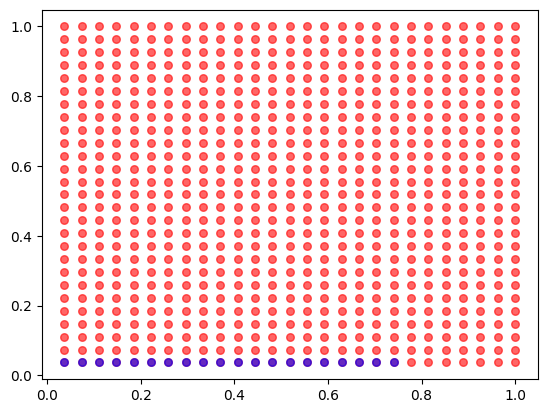

In [11]:
%matplotlib inline

plt.scatter(U[:, 0], U[:, 1], color='red', marker='o', s=30, alpha=0.6)
plt.scatter(U[:20, 0], U[:20, 1], color='blue', marker='o', s=30, alpha=0.6)
plt.show()

In [ ]:

Q = np.reshape(Y_hat, newshape=(T,) * d)

Q_functions: List[Array] = [np.array([np.nan])] * d
for axis in reversed(range(d)):
    # Calculate derivative along this axis
    dQ_du = (1 / T) * np.diff(Q, axis=axis)

    # Duplicate first "row" along axis and insert it first
    pad_with = [
        (0, 0),
    ] * d
    pad_with[axis] = (1, 0)
    dQ_du = np.pad(dQ_du, pad_width=pad_with, mode="edge")

    Q_functions[d - 1 - axis] = dQ_du * T**2

return tuple(Q_functions)
